## HW5

### Ahmad Hojatimalekshah

### Lets Load Libraries

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from sympy import *
from numpy.linalg import inv
from tabulate import tabulate
import math
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum

# 1. (a)

### Creating a dataframe from the datasets

In [2]:
df = pd.DataFrame(np.array([[0,8,28,41,63,79,97,117,135,154],[2,47,192,256,768,896,1120,896,1184,1024]]).T,
                 columns=['Days','Beetles'])
df.head()

,Days,Beetles
0,0,2
1,8,47
2,28,192
3,41,256
4,63,768


### Lets produce the function and its first derivative over **`k`** and **`r`**

In [3]:
r = sym.Symbol('r')
k = sym.Symbol('k')
t = sym.Symbol('t')
# N = sym.Symbol('N')
func = k*2/(2+(k-2)*sym.exp(-r*t))
fprime_r = sym.diff(func,r)
fprime_k = sym.diff(func,k)

f = lambdify([r,k,t],func)
f_r = lambdify([r,k,t],fprime_r, 'numpy')
f_k = lambdify([r,k,t],fprime_k, 'numpy')

#### Main Function

In [4]:
func

2*k/((k - 2)*exp(-r*t) + 2)

#### First derivative over r

In [5]:
fprime_r

2*k*t*(k - 2)*exp(-r*t)/((k - 2)*exp(-r*t) + 2)**2

#### First derivative over k

In [6]:
fprime_k

-2*k*exp(-r*t)/((k - 2)*exp(-r*t) + 2)**2 + 2/((k - 2)*exp(-r*t) + 2)

### Lets define a Function for Gauss-Newton 

In [7]:
def Newton_Gauss(r0,k0,N,t,eps):
    i = 0
    nitr = 1
    r1 = np.zeros(6)
    k1 = np.ones(6)
    SE_k = np.zeros(6)
    SE_r = np.zeros(6)
    corr = np.zeros(6)
    r1[0] = r0
    k1[0] = k0
    while sum(N-f(r1[i],k1[i],t))**2>eps:
        nitr +=1 
        if i==5:
            r1[0] = r1[i]
            k1[0] = k1[i]
            SE_r[0] = SE_r[i]
            SE_k[0] = SE_k[i]
            corr[0] = corr[i]
            i=0
        A = np.array([f_r(r1[i],k1[i],t),f_k(r1[i],k1[i],t)]).T    
        [r1[i+1],k1[i+1]] = [r1[i],k1[i]]+inv(A.T.dot(A)).dot(A.T).dot(N-f(r1[i],k1[i],t))
        SE_r[i+1] = np.sqrt(inv(A.T.dot(A)).diagonal())[0]*np.sqrt(sum((N-f(r1[i],k1[i],t))**2)/(len(N)-2))
        SE_k[i+1] = np.sqrt(inv(A.T.dot(A)).diagonal())[1]*np.sqrt(sum((N-f(r1[i],k1[i],t))**2)/(len(N)-2))
        corr[i+1] =  inv(A.T.dot(A))[0][1]/(np.sqrt(inv(A.T.dot(A)).diagonal())[0]*np.sqrt(inv(A.T.dot(A)).diagonal())[1])
        
        i+=1
        if nitr > 100:
            print('r and k estimates after 100 iterations:')
            break

    ID = np.concatenate((np.arange(nitr%5,5), np.arange(0,nitr%5)), axis=None)

    print(tabulate({"Iteration": list(np.arange(nitr-4,nitr+1)),'r' : list(r1[ID]), 'k': list(k1[ID]),
                    'SE for r': list(SE_r[ID]),'SE for k': list(SE_k[ID]), 'Correlation': list(corr[ID])},headers="keys"))

    return r1[i],k1[i]

### Lets see the last five iteration of Gauss-Newton method

In [8]:
r_gauss,k_gauss = Newton_Gauss(0.5,200,df['Beetles'],df['Days'],0.001)

r and k estimates after 100 iterations:
  Iteration         r        k    SE for r    SE for k    Correlation
-----------  --------  -------  ----------  ----------  -------------
         97  0.117959  1033.52  0.00777512     47.8238      -0.342842
         98  0.117959  1033.52  0.00777512     47.8238      -0.342842
         99  0.117959  1033.52  0.00777512     47.8238      -0.342842
        100  0.117959  1033.52  0.00777512     47.8238      -0.342842
        101  0.117959  1033.52  0.00777512     47.8238      -0.342842


### Scatter plot of the real data (observations) and the fitted model

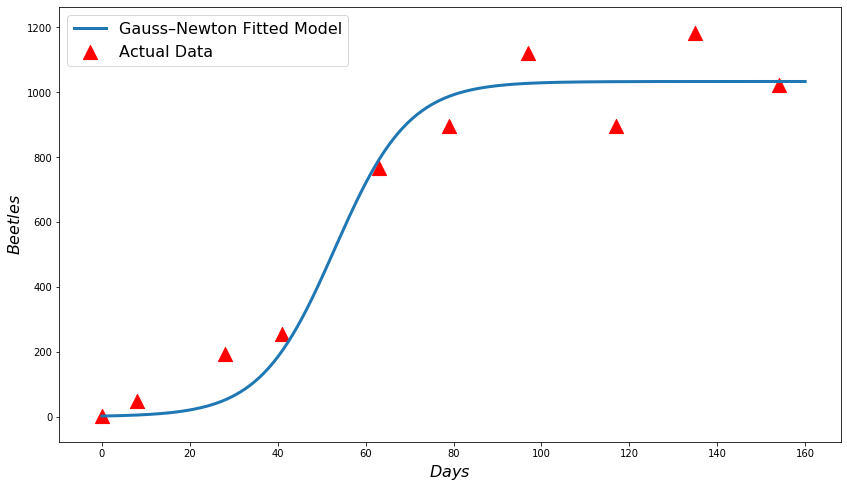

In [9]:
x = np.linspace(0,160,300)
y_gauss = f(r_gauss,k_gauss,x)
plt.figure(figsize=(14,8))
plt.plot(x,y_gauss,linewidth=3)
plt.xlabel('$Days$',weight='bold',fontsize=16)
plt.ylabel('$Beetles$',weight='bold',fontsize=16)
plt.scatter(df['Days'], df['Beetles'], s=200,c='red',marker='^')
plt.legend(("Gauss–Newton Fitted Model", "Actual Data"),fontsize=16)

## (b)

### we are going to minimize the function below:

$$\sum_{i=1}^{n} [(N_{i}-\frac{N_{0}k}{(k-N_{0})e^{-rt_{i}}+N_{0}})^{2}]$$

### Lets define a Function for Newton-Raphson method 

In [10]:
def Newton(r0,k0,t,N,eps):
    i = 0
    nitr = 1
    r1 = np.zeros(6)
    k1 = np.ones(6)
    SE_r = np.zeros(6)
    SE_k = np.zeros(6)
    corr = np.zeros(6)
    Hessian = np.zeros((10,2))
    r1[0] = r0
    k1[0] = k0
    while sum(N-g(r1[i],k1[i],t,N))**2>eps:
        nitr +=1 
        if i==5:
            r1[0] = r1[i]
            k1[0] = k1[i]
            Hessian[0:2,:] = H
            SE_r[0] = SE_r[i]
            SE_k[0] = SE_k[i]
            corr[0] = corr[i]
            i=0
        H= np.array([[sum(g_rr(r1[i],k1[i],t,N)),sum(g_rk(r1[i],k1[i],t,N))],[sum(g_rk(r1[i],k1[i],t,N)),sum(g_kk(r1[i],k1[i],t,N))]])    
        [[r1[i+1]],[k1[i+1]]] = [[r1[i]],[k1[i]]]-inv(H).dot([[sum(g_r(r1[i],k1[i],t,N))],[sum(g_k(r1[i],k1[i],t,N))]])
        Hessian[2*i:2*i+2,:] =H
        SE_r[i+1] = np.sqrt(inv(H)[0][0])
        SE_k[i+1] = np.sqrt(inv(H)[1][1])
        corr[i+1] = (inv(H)[0][1])/(np.sqrt(inv(H)[0][0])*np.sqrt(inv(H)[1][1]))
        i = i+1
        if nitr > 100:
            print('r and k estimates after 100 iterations:')
            break        
    ID = np.concatenate((np.arange(nitr%5,5), np.arange(0,nitr%5)), axis=None)


    print(tabulate({"Iteration": list(np.arange(nitr-4,nitr+1)),'\u03B11' : list(r1[ID]), '\u03B12': list(k1[ID]),
                   'Hessian Matrix':np.array(Hessian),'SE for r': list(SE_r[ID]),'SE for k': list(SE_k[ID]),
                   'Correlation': list(corr[ID])},headers="keys"))

    return r1[i],k1[i]

#### We need to define 
$$\sum_{i=1}^{n} [(N_{i}-\frac{N_{0}k}{(k-N_{0})e^{-rt_{i}}+N_{0}})^{2}]$$
#### as a function and take first and second derivative over r and k of it. $N_{0}=2$ according to the table in the book.

In [11]:
N = sym.Symbol('N')
g = (N-func)**2


gdprime_r = sym.diff(g,r,2)
gprime_r = sym.diff(g,r)
gprime_rk = sym.diff(gprime_r,k)
gprime_k = sym.diff(g,k)
gdprime_k = sym.diff(g,k,2)

g = lambdify([r,k,t,N],g)
g_rr = lambdify([r,k,t,N],gdprime_r, 'numpy')
g_kk = lambdify([r,k,t,N],gdprime_k, 'numpy')
g_rk = lambdify([r,k,t,N],gprime_rk, 'numpy')
g_r = lambdify([r,k,t,N],gprime_r, 'numpy')
g_k = lambdify([r,k,t,N],gprime_k, 'numpy')


### Lets see Newton-Raphson results

In [12]:
r_Newton,k_Newton = Newton(0.5,200,df['Days'],df['Beetles'],0.001)

r and k estimates after 100 iterations:
  Iteration        α1       α2  Hessian Matrix                      SE for r    SE for k    Correlation
-----------  --------  -------  -------------------------------  -----------  ----------  -------------
         97  0.117959  1033.52  [3.06558121e+08 2.32631481e+04]  6.27478e-05    0.342438      -0.414132
         98  0.117959  1033.52  [2.32631481e+04 1.02931051e+01]  6.27478e-05    0.342438      -0.414132
         99  0.117959  1033.52  [3.06558121e+08 2.32631481e+04]  6.27478e-05    0.342438      -0.414132
        100  0.117959  1033.52  [2.32631481e+04 1.02931051e+01]  6.27478e-05    0.342438      -0.414132
        101  0.117959  1033.52  [3.06558121e+08 2.32631481e+04]  6.27478e-05    0.342438      -0.414132
                                [2.32631481e+04 1.02931051e+01]
                                [3.06558121e+08 2.32631481e+04]
                                [2.32631481e+04 1.02931051e+01]
                                [3.06558

### Scatter plot of the real data (observations) and the fitted model

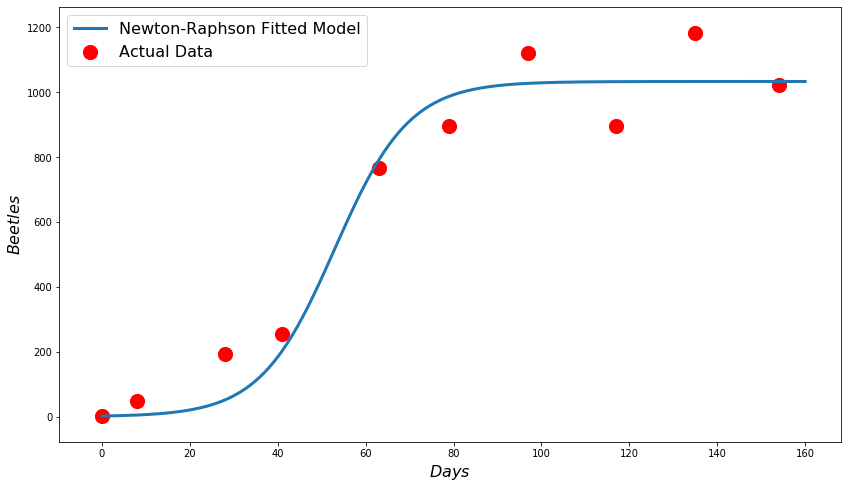

In [13]:
x = np.linspace(0,160,300)
y_Newton = f(r_Newton,k_Newton,x)
plt.figure(figsize=(14,8))
plt.plot(x,y_Newton,linewidth=3)
plt.xlabel('$Days$',weight='bold',fontsize=16)
plt.ylabel('$Beetles$',weight='bold',fontsize=16)
plt.scatter(df['Days'], df['Beetles'], s=200,c='red',marker='o')
plt.legend(("Newton-Raphson Fitted Model", "Actual Data"),fontsize=16)

## (c)

$Y_t = log N_t \sim N(log f(t), \sigma^2)$,

$f(t) = \frac{N_{0}k}{(k-N_{0})e^{-rt}+N_{0}}$

$\Rightarrow \frac{1}{\sqrt{2 \pi \sigma^2}}\exp(-\frac{[Y_{t_{i}}-log f(t_i)]^2}{2\sigma^2})$

and

$log [f(t)] = log k +log N_0 - log[N_0+(k-N_0) e^{-rt}]$

According to the likelihood definition:

$$L(k,r)= \prod_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma^2}}\exp(-\frac{[Y_{t_{i}}-log f(t_i)]^2}{2\sigma^2})$$

And the log-likelihood is:

$l(k,r)=log L(k,r)=\sum_{i = 1}^{n} log(\frac{1}{\sqrt{2 \pi \sigma^2}}) - \frac{1}{2\sigma^2}\sum_{i = 1}^{n} [Y_{t_{i}}-log f(t_i)]^2$

To find the MLE we need to minimize the $\sum_{i = 1}^{n} [Y_{t_{i}}-log f(t_i)]^2$  because $\frac{1}{2\sigma^2} $ (positive) and $\sum_{i = 1}^{n} log(\frac{1}{\sqrt{2 \pi \sigma^2}})$ are constants and do not depend on $r$ and $k$

### MLE by Gauss–Newton

#### We need to define a new function by taking logarithm from the previous function. Then we have to define new derivatives for that

In [14]:
r = sym.Symbol('r')
k = sym.Symbol('k')
t = sym.Symbol('t')

func = log(k*2/(2+(k-2)*exp(-r*t)))
fprime_r = sym.diff(func,r)
fprime_k = sym.diff(func,k)

f = lambdify([r,k,t],func)
f_r = lambdify([r,k,t],fprime_r, 'numpy')
f_k= lambdify([r,k,t],fprime_k, 'numpy')

### Lets see Gauss-Newton method's result for the new situation

In [15]:
r_gauss,k_gauss = Newton_Gauss(0.001,.02,np.log(df['Beetles']),df['Days'],0.001)

  Iteration         r        k    SE for r    SE for k    Correlation
-----------  --------  -------  ----------  ----------  -------------
          5  0.345974  132.672   0.523402      37.1595     -0.146636
          6  0.388238  347.995   0.274484      82.6989     -0.0710988
          7  0.399329  576.994   0.131353     114.48       -0.0431969
          8  0.40067   664.973   0.0912426    137.293      -0.0319063
          9  0.400505  672.044   0.0880074    154.128      -0.0294054


### Scatter plot of the real data (observations) and the fitted model

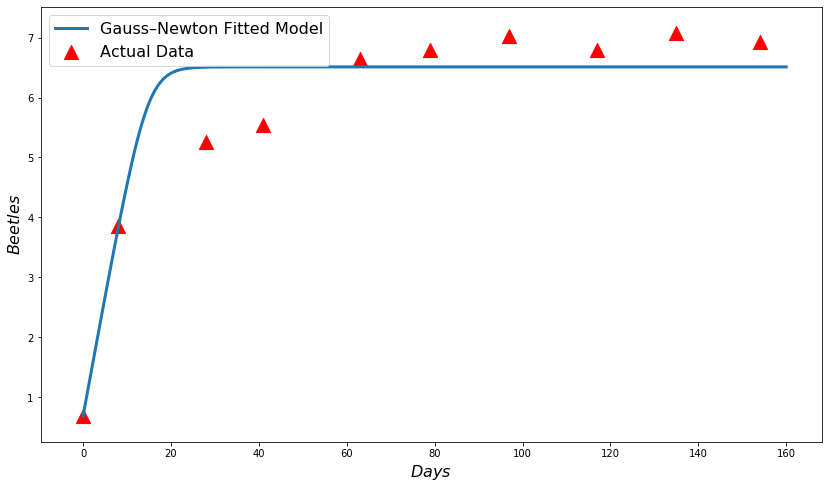

In [16]:
x = np.linspace(0,160,300)
y_gauss = f(r_gauss,k_gauss,x)
plt.figure(figsize=(14,8))
plt.plot(x,y_gauss,linewidth=3)
plt.xlabel('$Days$',weight='bold',fontsize=16)
plt.ylabel('$Beetles$',weight='bold',fontsize=16)
plt.scatter(df['Days'], np.log(df['Beetles']), s=200,c='red',marker='^')
plt.legend(("Gauss–Newton Fitted Model", "Actual Data"),fontsize=16)

### MLE by Newton-Raphson

#### we need to define a new function and compute its first and second derivatives

In [17]:
N = sym.Symbol('N')
g = (N-func)**2

gdprime_r = sym.diff(g,r,2)
gprime_r = sym.diff(g,r)
gprime_rk = sym.diff(gprime_r,k)
gprime_k = sym.diff(g,k)
gdprime_k = sym.diff(g,k,2)

g = lambdify([r,k,t,N],g)
g_rr = lambdify([r,k,t,N],gdprime_r, 'numpy')
g_kk = lambdify([r,k,t,N],gdprime_k, 'numpy')
g_rk = lambdify([r,k,t,N],gprime_rk, 'numpy')
g_r = lambdify([r,k,t,N],gprime_r, 'numpy')
g_k = lambdify([r,k,t,N],gprime_k, 'numpy')

### Lets see the Newton-Raphson results for that

In [18]:
r_Newton,k_Newton = Newton(0.5,200,df['Days'],np.log(df['Beetles']),0.001)

r and k estimates after 100 iterations:
  Iteration        α1       α2  Hessian Matrix                     SE for r    SE for k    Correlation
-----------  --------  -------  -------------------------------  ----------  ----------  -------------
         97  0.400461  672.091  [1.02425202e+02 2.27122131e-03]   0.0988794     168.238     -0.0377286
         98  0.400461  672.091  [2.27122131e-03 3.53810684e-05]   0.0988794     168.238     -0.0377286
         99  0.400461  672.091  [1.02425202e+02 2.27122131e-03]   0.0988794     168.238     -0.0377286
        100  0.400461  672.091  [2.27122131e-03 3.53810684e-05]   0.0988794     168.238     -0.0377286
        101  0.400461  672.091  [1.02425202e+02 2.27122131e-03]   0.0988794     168.238     -0.0377286
                                [2.27122131e-03 3.53810684e-05]
                                [1.02425202e+02 2.27122131e-03]
                                [2.27122131e-03 3.53810684e-05]
                                [1.02425202e+02

### Scatter plot of the real data (observations) and the fitted model

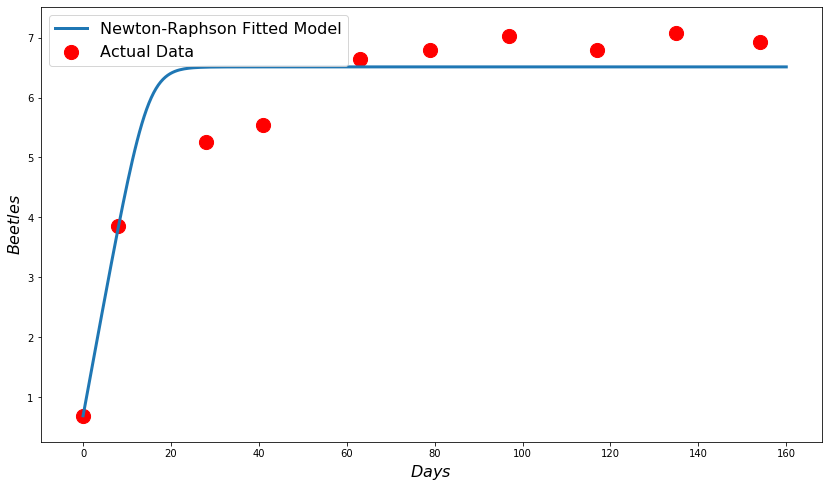

In [19]:
x = np.linspace(0,160,300)
y_Newton = f(r_Newton,k_Newton,x)
plt.figure(figsize=(14,8))
plt.plot(x,y_Newton,linewidth=3)
plt.xlabel('$Days$',weight='bold',fontsize=16)
plt.ylabel('$Beetles$',weight='bold',fontsize=16)
plt.scatter(df['Days'], np.log(df['Beetles']), s=200,c='red',marker='o')
plt.legend(("Newton-Raphson Fitted Model", "Actual Data"),fontsize=16)

**-Standard Error for the Newton-Raphson estimates is greater than Gauss-Newton's method and the correlation between two parameters for both methods is close to zero. However, Gauss-Newton's method is highly dependent on initial value selection and can easily fail to estimate the parameters correctly.**

# 2.

### Lets read the data

In [20]:
x = np.array([85,196,341])
n = zeros(6)
p = np.array([1/3,1/3,1/3])
itr = 50

### We define Expectation function

In [21]:
def E_step(x,p):
    cc = x[0]*(p[0]**2)/(p[0]**2+2*p[0]*p[1]+2*p[0]*p[2])
    ci = 2*x[0]*p[0]*p[1]/(p[0]**2+2*p[0]*p[1]+2*p[0]*p[2])
    ct = 2*x[0]*p[0]*p[2]/(p[0]**2+2*p[0]*p[1]+2*p[0]*p[2])
    ii = x[1]*(p[1]**2)/(p[1]**2+2*p[1]*p[2])
    it = 2*x[1]*p[1]*p[2]/(p[1]**2+2*p[1]*p[2])
    n = np.array([cc,ci,ct,ii,it,x[2]])
    return n

### The next step is to define a function Maximization

In [22]:
def M_step(x,n):
    c = (2*n[0]+n[1]+n[2])/(2*sum(x))
    i = (2*n[3]+n[4]+n[1])/(2*sum(x))
    t = (2*n[5]+n[2]+n[4])/(2*sum(x))
    p = np.array([c,i,t])
    return p

### We produce Expectation and Maximum 

In [23]:
p1=p
for i in np.arange(1,itr):
    n1 = E_step(x,p1)
    p1 = M_step(x,n1)

### EM optimization function

In [24]:
def EM(x,p,p1,eps):
    R=1
    itr=0
    header=['Iteration','P_C\u207D\u1d57\u207E', 'P_I\u207D\u1d57\u207E',
            'R\u207D\u1d57\u207E',"D_C\u207D\u1d57\u207E",'D_I\u207D\u1d57\u207E']
    if itr==0:
        table = [[itr,p[0],p[1],None,None,None]]
        print(tabulate(table,headers=header))
        
    while R > eps:
        p0=p
        n = E_step(x,p)
        p = M_step(x,n)
        R = np.sqrt(sum((p[0:2]-p0[0:2])**2))/np.sqrt(sum(p0[0:2]**2))
        D_c = (p[0] - p1[0]) / (p0[0] - p1[0])
        D_i = (p[1] - p1[1]) / (p0[1] - p1[1])
        table = [[itr,p[0],p[1],R,D_c,D_i]]
        print(tabulate(table,headers=header))     
        itr+=1


### EM results

In [25]:
EM(x,p,p1,0.00001)

  Iteration    P_C⁽ᵗ⁾    P_I⁽ᵗ⁾  R⁽ᵗ⁾    D_C⁽ᵗ⁾    D_I⁽ᵗ⁾
-----------  --------  --------  ------  --------  --------
          0  0.333333  0.333333
  Iteration     P_C⁽ᵗ⁾    P_I⁽ᵗ⁾      R⁽ᵗ⁾     D_C⁽ᵗ⁾    D_I⁽ᵗ⁾
-----------  ---------  --------  --------  ---------  --------
          0  0.0819936  0.237406  0.570685  0.0425021  0.336589
  Iteration    P_C⁽ᵗ⁾    P_I⁽ᵗ⁾      R⁽ᵗ⁾     D_C⁽ᵗ⁾    D_I⁽ᵗ⁾
-----------  --------  --------  --------  ---------  --------
          1  0.071249   0.19787  0.163121  0.0369326  0.187655
  Iteration    P_C⁽ᵗ⁾    P_I⁽ᵗ⁾      R⁽ᵗ⁾     D_C⁽ᵗ⁾    D_I⁽ᵗ⁾
-----------  --------  --------  --------  ---------  --------
          2  0.070852   0.19036  0.035756  0.0367268  0.177799
  Iteration     P_C⁽ᵗ⁾    P_I⁽ᵗ⁾        R⁽ᵗ⁾     D_C⁽ᵗ⁾    D_I⁽ᵗ⁾
-----------  ---------  --------  ----------  ---------  --------
          3  0.0708375  0.189023  0.00658604  0.0367193  0.176241
  Iteration     P_C⁽ᵗ⁾    P_I⁽ᵗ⁾        R⁽ᵗ⁾    D_C⁽ᵗ⁾    D_I⁽ᵗ⁾
-----------  ----